# Train and evaluate a 3D Convolutional Neural Network (3dCNN) to classify the entire HCP task catalogue

<p style='text-align: justify;'>In this notebook we create and train a 3D-Convolutional Neural Network which learns to classify different patterns of whole-brain fMRI statistical parameters (t-scores). In this first approach our goal is to train a classifier that can reliably distinguish between such whole-brain patterns for five limb movements (i.e., left/right hand, left/right foot, and tongue).

</p>

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
import os, wandb, torch, time
import pandas as pd
import numpy as np
from glob import glob
from torch.utils.data import DataLoader
from torchinfo import summary
import seaborn as sns
import matplotlib.pyplot as plt

from delphi import mni_template
from delphi.networks.ConvNets import BrainStateClassifier3d
from delphi.utils.datasets import NiftiDataset
from delphi.utils.tools import ToTensor, compute_accuracy, convert_wandb_config, read_config, z_transform_volume
from delphi.utils.plots import confusion_matrix

from sklearn.model_selection import StratifiedShuffleSplit

# you can find all these files in ../utils
from utils.tools import attribute_with_method, concat_stat_files, compute_mi
from utils.wandb_funcs import reset_wandb_env, wandb_plots
from utils.random import set_random_seed

from tqdm.notebook import tqdm

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<p style='text-align: justify;'>To make sure that we obtain (almost) the same results for each execution we set the random seed of multiple different librabries (i.e., torch, random, numpy)</p>

In [5]:
g = set_random_seed(2020) # the project started in the year 2020, hence the seed

## Initializations

In this section, we define and initialize our required variables. We first need to define which classes we want to predict, i.e., the conditions of the motor mapper. We then define a PyTorch dataset; in this case `NiftiDataset` is a custom written Dataset-Class (see https://github.com/PhilippS893/delphi). As is common practice in machine learning projects, we split our data into a training and validation dataset (ratio=80 to 20, respectively).

Note: In case it is necessary to create a null-model, i.e., a neural network that is trained on data where the labels are randomized, one can set the parameter `shuffe_labels=False` to `True`. This is usually done to have a baseline for the null hypothesis that "everything is random".

In [6]:
class_labels = ["footleft", "footright", "handleft", "handright", "tongue", 
                "loss", "reward", 
                "mental", "random", 
                "body", "face", "place", "tool", 
                "match", "relation", 
                "emotion", "neut", 
                "story", "math"]
data_test = NiftiDataset("../t-maps/test", class_labels, 0, device=DEVICE, transform=ToTensor())

<p style='text-align: justify;'>We now set some parameters required by w&b to properly store information about our trained neural networks.</p>

# Identify the best fold

In [7]:
from utils.wandb_funcs import get_wandb_csv

In [8]:
keys_of_interest = ['group', 'job_type', 'run_name', 'test_accuracy', 'train_acc', 'valid_acc', 
                    'valid_loss', 'best_valid_epoch', 'best_valid_accuracy', 'test_loss', 'train_loss']
wandb_df = get_wandb_csv("philis893", "thesis", "full-hcp", keys_of_interest, job_name="CV-7folds-real", overwrite=True)

real_runs = wandb_df[wandb_df.job_type == "CV-7folds-real"]
# sort according to best_valid_accuracy (desc), test_accuracy (desc), and test_loss (asc). Take the first entry => best fold
real_runs_sorted = real_runs.sort_values(["best_valid_accuracy", "test_accuracy", "test_loss"], ascending=[False, False, True])
real_runs_sorted.head(1)

{'entity': 'philis893', 'project': 'thesis', 'filters': {'group_name': {'$regex': 'full-hcp.*'}, 'jobType': 'CV-7folds-real'}, 'order': '-created_at', '_sweeps': {}, 'client': <wandb.apis.public.RetryingClient object at 0x7f62da07ad60>, 'variables': {'project': 'thesis', 'entity': 'philis893', 'order': '-created_at', 'filters': '{"group_name": {"$regex": "full-hcp.*"}, "jobType": "CV-7folds-real"}'}, 'per_page': 50, 'objects': [], 'index': -1, 'last_response': None}


,group,job_type,run_name,test_accuracy,train_acc,valid_acc,valid_loss,best_valid_epoch,best_valid_accuracy,test_loss,train_loss
5,full-hcp,CV-7folds-real,seed-2020_fold-01,0.876316,0.924561,0.860526,0.334964,50,0.902632,0.354409,0.181635


In [9]:
BEST_FOLD = 1;

# SANITY CHECKS FOR RELEVANCE/XAI
## OCCLUSION (faithfulness test)

In [9]:
from delphi.utils.tools import occlude_images
from utils.tools import run_pca, run_svm, predict
import pickle as pk
from nilearn.image import load_img, index_img, concat_imgs
from nilearn.masking import apply_mask

In [ ]:
def occlude_images(images, attributions, mask, fraction=1, get_fdata=False) -> nib.Nifti1Image:
    """

    Args:
        images:
        attributions:
        mask:
        fraction:   voxel percentage to occlude (default=1%)
        get_fdata:  in case one wants to get the numpy arrays already.

    Returns:

    """
    from nilearn.masking import apply_mask, unmask

    fraction = fraction / 100

    # mask the images such that we only really consider brain voxels
    images_masked = apply_mask(images, mask)
    attributions_masked = apply_mask(attributions, mask)

    # find the indices of the largest n voxels for each attribution image (number depends on fraction)
    if len(attributions_masked.shape) < 2:
        occlusion_indices = np.argsort(a=attributions_masked)[::-1]  # this means we find the largest.
        occlusion_indices = occlusion_indices[:int(fraction * occlusion_indices.shape[-1])]
    else:
        occlusion_indices = np.argsort(a=attributions_masked, axis=1)[:, ::-1]  # this means we find the largest.
        occlusion_indices = occlusion_indices[:, :int(fraction * occlusion_indices.shape[-1])]

    # dummy for occluded images
    occluded_images = np.array(images_masked)
    occluded_images[:, occlusion_indices] = 0

    # convert the occluded_images back into 3d nibabel format
    if not get_fdata:
        return unmask(occluded_images, mask), occlusion_indices.shape[-1]
    else:
        return unmask(occluded_images, mask).get_fdata(), occlusion_indices.shape[-1]

In [14]:
percentages = np.concatenate([
    np.arange(0, 2, .2),
    np.arange(2, 5, .5),
    np.arange(5, 10, 1),
    np.arange(10, 32, 2)
])

mask = mni_template

### Load SVM Stuff

In [9]:
images = []
for c, label in tqdm(enumerate(class_labels), leave=False, desc="class"):
    images.append(load_img(glob(f"../t-maps/test/{label}/*.nii.gz")))

class: 0it [00:00, ?it/s]

In [25]:
# load the decision boundary maps (i.e., the weight maps of the SVM; we can consider those to be the "explanation" of the SVM)
n_folds = 7
df_svm = []
real = np.repeat(np.arange(len(class_labels)), 20)

if not os.path.exists("stats/svm_occlusion_curves.csv"):

    for f in range(n_folds):

        svm_files = load_img(f"../00_svm/svm_maps/nsubs-120/k-fold_ss-0mm_fold{f:02d}_ovr_120subs_2280dims_seed2020.nii.gz")
        pca_file = f"../00_svm/pca_models/nsubs-120/k-fold_ss-0mm_fold{f:02d}_2280samples_seed{2020+f}.pkl"
        with open(pca_file, 'rb') as pickle_file:
            pca = pk.load(pickle_file)

        svm_file = f"../00_svm/svm_models/nsubs-120/k-fold_ss-0mm_fold{f:02d}_ovr_120subs_2280dims_seed2020.pkl"
        with open(svm_file, 'rb') as pickle_file:
            svm = pk.load(pickle_file)

        accs = np.zeros(len(percentages))   

        for i, frac in tqdm(enumerate(percentages), leave=True, desc="fractions"):
            occluded = []
            for c, label in enumerate(class_labels):
                # load the data
                occu, _ = occlude_images(images[c], index_img(svm_files , c), mask, fraction=frac, get_fdata=False)
                occluded.append(occu)
            occluded = concat_imgs(occluded)
            occluded = apply_mask(occluded, mni_template)
            # transform the data
            occluded = pca.transform(occluded)
            _, accs[i] = predict(svm, occluded, real)
            #print(accs[i])

        df_svm.append(pd.DataFrame(accs.tolist(), columns=["accuracy"]))
        df_svm[f]["algorithm"] = "svm"
        df_svm[f]["prct_occluded"] = percentages

    df_stacked = pd.concat(df_svm)
    df_stacked.to_csv("stats/svm_occlusion_curves.csv", index=False)
else:
    print("Already exists. Loading instead")
    df_stacked = pd.read_csv("stats/svm_occlusion_curves.csv")

Already exists. Loading instead


### Load DNN stuff

In [27]:
# load the t-scores for each subject
test_img_files = []
[test_img_files.extend(glob(f"../t-maps/test/{class_labels[i]}/*.nii.gz")) for i in range(len(class_labels))]
images = load_img(test_img_files)

In [29]:
xai_algo = ["lrp", "guidedbackprop"]

df_occlu = []

if not os.path.isfile("stats/dnn_occlusion_curves.csv"):

    for i, algo in enumerate(xai_algo):

        folds = sorted(glob(os.path.join(algo, "real", "*fold*")))

        for f, fold in enumerate(folds):
            # load the trained network
            model = BrainStateClassifier3d(f"models/CV-7folds-real/seed-2020_fold-{f:02d}")
            model.eval()
            model.to(torch.device("cpu"));

            relevance_files = sorted(glob(os.path.join(fold, "*nii.gz")))
            relevance_maps = load_img(relevance_files)

            accs = np.zeros(len(percentages))

            for i, frac in tqdm(enumerate(percentages), desc="percentages"):
                print(fold, i)
                occluded, _ = occlude_images(images, relevance_maps, mask, fraction=frac, get_fdata=True)
                occluded = np.moveaxis(occluded, -1, 0)
                occluded = torch.tensor(occluded).unsqueeze(1)
                pred = np.argmax(model(occluded.float()).detach().cpu().numpy(), axis=1)
                accs[i] = compute_accuracy(real, pred)
                print(accs[i])

            df_inter = pd.DataFrame(accs.tolist(), columns=["accuracy"])
            df_inter["algorithm"] = algo
            df_inter["prct_occluded"] = percentages

            df_occlu.append(df_inter)

    df_occlusion = pd.concat(df_occlu)
    df_occlusion.to_csv("stats/dnn_occlusion_curves.csv", index=False)
else:
    df_occlusion = pd.read_csv("stats/dnn_occlusion_curves.csv")

Loading from config file models/CV-7folds-real/seed-2020_fold-00/config.yaml


percentages: 0it [00:00, ?it/s]

lrp/real/fold-00 0
0.868421052631579
lrp/real/fold-00 1
0.3526315789473684
lrp/real/fold-00 2
0.16842105263157894
lrp/real/fold-00 3
0.0868421052631579
lrp/real/fold-00 4
0.05526315789473684
lrp/real/fold-00 5
0.05263157894736842
lrp/real/fold-00 6
0.05263157894736842
lrp/real/fold-00 7
0.05263157894736842
lrp/real/fold-00 8
0.05263157894736842
lrp/real/fold-00 9
0.05263157894736842
lrp/real/fold-00 10
0.05263157894736842
lrp/real/fold-00 11
0.05263157894736842
lrp/real/fold-00 12
0.05263157894736842
lrp/real/fold-00 13
0.05263157894736842
lrp/real/fold-00 14
0.05263157894736842
lrp/real/fold-00 15
0.05263157894736842
lrp/real/fold-00 16
0.05263157894736842
lrp/real/fold-00 17
0.05263157894736842
lrp/real/fold-00 18
0.05263157894736842
lrp/real/fold-00 19
0.05263157894736842
lrp/real/fold-00 20
0.05263157894736842
lrp/real/fold-00 21
0.05263157894736842
lrp/real/fold-00 22
0.05263157894736842
lrp/real/fold-00 23
0.05263157894736842
lrp/real/fold-00 24
0.05263157894736842
lrp/real/fold-

percentages: 0it [00:00, ?it/s]

lrp/real/fold-01 0
0.8868421052631579
lrp/real/fold-01 1
0.3
lrp/real/fold-01 2
0.15263157894736842
lrp/real/fold-01 3
0.09736842105263158
lrp/real/fold-01 4
0.06842105263157895
lrp/real/fold-01 5
0.04736842105263158
lrp/real/fold-01 6
0.06315789473684211
lrp/real/fold-01 7
0.05789473684210526
lrp/real/fold-01 8
0.060526315789473685
lrp/real/fold-01 9
0.05526315789473684
lrp/real/fold-01 10
0.05526315789473684
lrp/real/fold-01 11
0.05263157894736842
lrp/real/fold-01 12
0.05263157894736842
lrp/real/fold-01 13
0.05263157894736842
lrp/real/fold-01 14
0.05263157894736842
lrp/real/fold-01 15
0.05263157894736842
lrp/real/fold-01 16
0.05263157894736842
lrp/real/fold-01 17
0.05263157894736842
lrp/real/fold-01 18
0.05263157894736842
lrp/real/fold-01 19
0.05263157894736842
lrp/real/fold-01 20
0.05263157894736842
lrp/real/fold-01 21
0.05263157894736842
lrp/real/fold-01 22
0.05263157894736842
lrp/real/fold-01 23
0.05263157894736842
lrp/real/fold-01 24
0.05263157894736842
lrp/real/fold-01 25
0.0526

percentages: 0it [00:00, ?it/s]

lrp/real/fold-02 0
0.868421052631579
lrp/real/fold-02 1
0.28421052631578947
lrp/real/fold-02 2
0.11315789473684211
lrp/real/fold-02 3
0.07894736842105263
lrp/real/fold-02 4
0.05789473684210526
lrp/real/fold-02 5
0.05789473684210526
lrp/real/fold-02 6
0.05789473684210526
lrp/real/fold-02 7
0.05
lrp/real/fold-02 8
0.05263157894736842
lrp/real/fold-02 9
0.05263157894736842
lrp/real/fold-02 10
0.05263157894736842
lrp/real/fold-02 11
0.05263157894736842
lrp/real/fold-02 12
0.05263157894736842
lrp/real/fold-02 13
0.05263157894736842
lrp/real/fold-02 14
0.05263157894736842
lrp/real/fold-02 15
0.05263157894736842
lrp/real/fold-02 16
0.05263157894736842
lrp/real/fold-02 17
0.05263157894736842
lrp/real/fold-02 18
0.05263157894736842
lrp/real/fold-02 19
0.05263157894736842
lrp/real/fold-02 20
0.05263157894736842
lrp/real/fold-02 21
0.05263157894736842
lrp/real/fold-02 22
0.05263157894736842
lrp/real/fold-02 23
0.05263157894736842
lrp/real/fold-02 24
0.05263157894736842
lrp/real/fold-02 25
0.05263

percentages: 0it [00:00, ?it/s]

lrp/real/fold-03 0
0.8736842105263158
lrp/real/fold-03 1
0.36578947368421055
lrp/real/fold-03 2
0.18157894736842106
lrp/real/fold-03 3
0.08947368421052632
lrp/real/fold-03 4
0.06315789473684211
lrp/real/fold-03 5
0.05789473684210526
lrp/real/fold-03 6
0.05263157894736842
lrp/real/fold-03 7
0.05263157894736842
lrp/real/fold-03 8
0.05263157894736842
lrp/real/fold-03 9
0.05263157894736842
lrp/real/fold-03 10
0.05263157894736842
lrp/real/fold-03 11
0.05263157894736842
lrp/real/fold-03 12
0.05263157894736842
lrp/real/fold-03 13
0.05263157894736842
lrp/real/fold-03 14
0.05263157894736842
lrp/real/fold-03 15
0.03684210526315789
lrp/real/fold-03 16
0.02894736842105263
lrp/real/fold-03 17
0.05263157894736842
lrp/real/fold-03 18
0.05263157894736842
lrp/real/fold-03 19
0.05263157894736842
lrp/real/fold-03 20
0.05263157894736842
lrp/real/fold-03 21
0.05263157894736842
lrp/real/fold-03 22
0.05263157894736842
lrp/real/fold-03 23
0.05263157894736842
lrp/real/fold-03 24
0.05263157894736842
lrp/real/fo

percentages: 0it [00:00, ?it/s]

lrp/real/fold-04 0
0.8710526315789474
lrp/real/fold-04 1
0.31842105263157894
lrp/real/fold-04 2
0.14210526315789473
lrp/real/fold-04 3
0.08157894736842106
lrp/real/fold-04 4
0.06315789473684211
lrp/real/fold-04 5
0.05263157894736842
lrp/real/fold-04 6
0.05
lrp/real/fold-04 7
0.05
lrp/real/fold-04 8
0.05526315789473684
lrp/real/fold-04 9
0.05263157894736842
lrp/real/fold-04 10
0.04473684210526316
lrp/real/fold-04 11
0.05
lrp/real/fold-04 12
0.05263157894736842
lrp/real/fold-04 13
0.05263157894736842
lrp/real/fold-04 14
0.05263157894736842
lrp/real/fold-04 15
0.05263157894736842
lrp/real/fold-04 16
0.05263157894736842
lrp/real/fold-04 17
0.05263157894736842
lrp/real/fold-04 18
0.05263157894736842
lrp/real/fold-04 19
0.05263157894736842
lrp/real/fold-04 20
0.05263157894736842
lrp/real/fold-04 21
0.05263157894736842
lrp/real/fold-04 22
0.05263157894736842
lrp/real/fold-04 23
0.05263157894736842
lrp/real/fold-04 24
0.05263157894736842
lrp/real/fold-04 25
0.05263157894736842
lrp/real/fold-04

percentages: 0it [00:00, ?it/s]

lrp/real/fold-05 0
0.8921052631578947
lrp/real/fold-05 1
0.3684210526315789
lrp/real/fold-05 2
0.15789473684210525
lrp/real/fold-05 3
0.08157894736842106
lrp/real/fold-05 4
0.060526315789473685
lrp/real/fold-05 5
0.05526315789473684
lrp/real/fold-05 6
0.03684210526315789
lrp/real/fold-05 7
0.039473684210526314
lrp/real/fold-05 8
0.05
lrp/real/fold-05 9
0.04736842105263158
lrp/real/fold-05 10
0.04473684210526316
lrp/real/fold-05 11
0.04473684210526316
lrp/real/fold-05 12
0.042105263157894736
lrp/real/fold-05 13
0.04736842105263158
lrp/real/fold-05 14
0.05
lrp/real/fold-05 15
0.05263157894736842
lrp/real/fold-05 16
0.05263157894736842
lrp/real/fold-05 17
0.05263157894736842
lrp/real/fold-05 18
0.05263157894736842
lrp/real/fold-05 19
0.05263157894736842
lrp/real/fold-05 20
0.05263157894736842
lrp/real/fold-05 21
0.05263157894736842
lrp/real/fold-05 22
0.05263157894736842
lrp/real/fold-05 23
0.05263157894736842
lrp/real/fold-05 24
0.05263157894736842
lrp/real/fold-05 25
0.05263157894736842

percentages: 0it [00:00, ?it/s]

lrp/real/fold-06 0
0.8736842105263158
lrp/real/fold-06 1
0.3631578947368421
lrp/real/fold-06 2
0.1394736842105263
lrp/real/fold-06 3
0.07894736842105263
lrp/real/fold-06 4
0.04473684210526316
lrp/real/fold-06 5
0.05789473684210526
lrp/real/fold-06 6
0.05
lrp/real/fold-06 7
0.05263157894736842
lrp/real/fold-06 8
0.05526315789473684
lrp/real/fold-06 9
0.05263157894736842
lrp/real/fold-06 10
0.05263157894736842
lrp/real/fold-06 11
0.05263157894736842
lrp/real/fold-06 12
0.05263157894736842
lrp/real/fold-06 13
0.05263157894736842
lrp/real/fold-06 14
0.05263157894736842
lrp/real/fold-06 15
0.05263157894736842
lrp/real/fold-06 16
0.05263157894736842
lrp/real/fold-06 17
0.05263157894736842
lrp/real/fold-06 18
0.05263157894736842
lrp/real/fold-06 19
0.05263157894736842
lrp/real/fold-06 20
0.05263157894736842
lrp/real/fold-06 21
0.05263157894736842
lrp/real/fold-06 22
0.05263157894736842
lrp/real/fold-06 23
0.05263157894736842
lrp/real/fold-06 24
0.05263157894736842
lrp/real/fold-06 25
0.052631

percentages: 0it [00:00, ?it/s]

guidedbackprop/real/fold-00 0
0.868421052631579
guidedbackprop/real/fold-00 1
0.28157894736842104
guidedbackprop/real/fold-00 2
0.16578947368421051
guidedbackprop/real/fold-00 3
0.11315789473684211
guidedbackprop/real/fold-00 4
0.07368421052631578
guidedbackprop/real/fold-00 5
0.05526315789473684
guidedbackprop/real/fold-00 6
0.06315789473684211
guidedbackprop/real/fold-00 7
0.05263157894736842
guidedbackprop/real/fold-00 8
0.05526315789473684
guidedbackprop/real/fold-00 9
0.05263157894736842
guidedbackprop/real/fold-00 10
0.05263157894736842
guidedbackprop/real/fold-00 11
0.05263157894736842
guidedbackprop/real/fold-00 12
0.05263157894736842
guidedbackprop/real/fold-00 13
0.05263157894736842
guidedbackprop/real/fold-00 14
0.05263157894736842
guidedbackprop/real/fold-00 15
0.05263157894736842
guidedbackprop/real/fold-00 16
0.05263157894736842
guidedbackprop/real/fold-00 17
0.05263157894736842
guidedbackprop/real/fold-00 18
0.05263157894736842
guidedbackprop/real/fold-00 19
0.0526315789

percentages: 0it [00:00, ?it/s]

guidedbackprop/real/fold-01 0
0.8868421052631579
guidedbackprop/real/fold-01 1
0.3473684210526316
guidedbackprop/real/fold-01 2
0.19210526315789472
guidedbackprop/real/fold-01 3
0.11842105263157894
guidedbackprop/real/fold-01 4
0.09473684210526316
guidedbackprop/real/fold-01 5
0.1
guidedbackprop/real/fold-01 6
0.07368421052631578
guidedbackprop/real/fold-01 7
0.08421052631578947
guidedbackprop/real/fold-01 8
0.060526315789473685
guidedbackprop/real/fold-01 9
0.05526315789473684
guidedbackprop/real/fold-01 10
0.05789473684210526
guidedbackprop/real/fold-01 11
0.05263157894736842
guidedbackprop/real/fold-01 12
0.05263157894736842
guidedbackprop/real/fold-01 13
0.05263157894736842
guidedbackprop/real/fold-01 14
0.05263157894736842
guidedbackprop/real/fold-01 15
0.05263157894736842
guidedbackprop/real/fold-01 16
0.05263157894736842
guidedbackprop/real/fold-01 17
0.05263157894736842
guidedbackprop/real/fold-01 18
0.05263157894736842
guidedbackprop/real/fold-01 19
0.05263157894736842
guidedb

percentages: 0it [00:00, ?it/s]

guidedbackprop/real/fold-02 0
0.868421052631579
guidedbackprop/real/fold-02 1
0.39210526315789473
guidedbackprop/real/fold-02 2
0.21842105263157896
guidedbackprop/real/fold-02 3
0.15
guidedbackprop/real/fold-02 4
0.11052631578947368
guidedbackprop/real/fold-02 5
0.08421052631578947
guidedbackprop/real/fold-02 6
0.06842105263157895
guidedbackprop/real/fold-02 7
0.05789473684210526
guidedbackprop/real/fold-02 8
0.05789473684210526
guidedbackprop/real/fold-02 9
0.05526315789473684
guidedbackprop/real/fold-02 10
0.05526315789473684
guidedbackprop/real/fold-02 11
0.05263157894736842
guidedbackprop/real/fold-02 12
0.05263157894736842
guidedbackprop/real/fold-02 13
0.05263157894736842
guidedbackprop/real/fold-02 14
0.05263157894736842
guidedbackprop/real/fold-02 15
0.05263157894736842
guidedbackprop/real/fold-02 16
0.05263157894736842
guidedbackprop/real/fold-02 17
0.05263157894736842
guidedbackprop/real/fold-02 18
0.05263157894736842
guidedbackprop/real/fold-02 19
0.05263157894736842
guidedb

percentages: 0it [00:00, ?it/s]

guidedbackprop/real/fold-03 0
0.8736842105263158
guidedbackprop/real/fold-03 1
0.4421052631578947
guidedbackprop/real/fold-03 2
0.2657894736842105
guidedbackprop/real/fold-03 3
0.18947368421052632
guidedbackprop/real/fold-03 4
0.1368421052631579
guidedbackprop/real/fold-03 5
0.12105263157894737
guidedbackprop/real/fold-03 6
0.1
guidedbackprop/real/fold-03 7
0.09473684210526316
guidedbackprop/real/fold-03 8
0.0868421052631579
guidedbackprop/real/fold-03 9
0.08157894736842106
guidedbackprop/real/fold-03 10
0.07894736842105263
guidedbackprop/real/fold-03 11
0.07105263157894737
guidedbackprop/real/fold-03 12
0.05526315789473684
guidedbackprop/real/fold-03 13
0.05263157894736842
guidedbackprop/real/fold-03 14
0.05263157894736842
guidedbackprop/real/fold-03 15
0.05263157894736842
guidedbackprop/real/fold-03 16
0.05263157894736842
guidedbackprop/real/fold-03 17
0.05789473684210526
guidedbackprop/real/fold-03 18
0.05526315789473684
guidedbackprop/real/fold-03 19
0.05
guidedbackprop/real/fold-0

percentages: 0it [00:00, ?it/s]

guidedbackprop/real/fold-04 0
0.8710526315789474
guidedbackprop/real/fold-04 1
0.2657894736842105
guidedbackprop/real/fold-04 2
0.16842105263157894
guidedbackprop/real/fold-04 3
0.11578947368421053
guidedbackprop/real/fold-04 4
0.0868421052631579
guidedbackprop/real/fold-04 5
0.07894736842105263
guidedbackprop/real/fold-04 6
0.07105263157894737
guidedbackprop/real/fold-04 7
0.06315789473684211
guidedbackprop/real/fold-04 8
0.04736842105263158
guidedbackprop/real/fold-04 9
0.04736842105263158
guidedbackprop/real/fold-04 10
0.03684210526315789
guidedbackprop/real/fold-04 11
0.04736842105263158
guidedbackprop/real/fold-04 12
0.05
guidedbackprop/real/fold-04 13
0.05263157894736842
guidedbackprop/real/fold-04 14
0.05263157894736842
guidedbackprop/real/fold-04 15
0.05263157894736842
guidedbackprop/real/fold-04 16
0.05263157894736842
guidedbackprop/real/fold-04 17
0.05263157894736842
guidedbackprop/real/fold-04 18
0.05263157894736842
guidedbackprop/real/fold-04 19
0.05263157894736842
guidedba

percentages: 0it [00:00, ?it/s]

guidedbackprop/real/fold-05 0
0.8921052631578947
guidedbackprop/real/fold-05 1
0.45526315789473687
guidedbackprop/real/fold-05 2
0.24736842105263157
guidedbackprop/real/fold-05 3
0.12894736842105264
guidedbackprop/real/fold-05 4
0.09210526315789473
guidedbackprop/real/fold-05 5
0.07105263157894737
guidedbackprop/real/fold-05 6
0.06315789473684211
guidedbackprop/real/fold-05 7
0.06842105263157895
guidedbackprop/real/fold-05 8
0.05789473684210526
guidedbackprop/real/fold-05 9
0.060526315789473685
guidedbackprop/real/fold-05 10
0.05263157894736842
guidedbackprop/real/fold-05 11
0.04736842105263158
guidedbackprop/real/fold-05 12
0.03684210526315789
guidedbackprop/real/fold-05 13
0.04736842105263158
guidedbackprop/real/fold-05 14
0.042105263157894736
guidedbackprop/real/fold-05 15
0.05263157894736842
guidedbackprop/real/fold-05 16
0.05526315789473684
guidedbackprop/real/fold-05 17
0.05263157894736842
guidedbackprop/real/fold-05 18
0.05263157894736842
guidedbackprop/real/fold-05 19
0.0526315

percentages: 0it [00:00, ?it/s]

guidedbackprop/real/fold-06 0
0.8736842105263158
guidedbackprop/real/fold-06 1
0.3894736842105263
guidedbackprop/real/fold-06 2
0.21578947368421053
guidedbackprop/real/fold-06 3
0.12368421052631579
guidedbackprop/real/fold-06 4
0.07368421052631578
guidedbackprop/real/fold-06 5
0.05526315789473684
guidedbackprop/real/fold-06 6
0.04473684210526316
guidedbackprop/real/fold-06 7
0.05
guidedbackprop/real/fold-06 8
0.05263157894736842
guidedbackprop/real/fold-06 9
0.05
guidedbackprop/real/fold-06 10
0.05789473684210526
guidedbackprop/real/fold-06 11
0.05263157894736842
guidedbackprop/real/fold-06 12
0.05263157894736842
guidedbackprop/real/fold-06 13
0.05263157894736842
guidedbackprop/real/fold-06 14
0.05263157894736842
guidedbackprop/real/fold-06 15
0.05263157894736842
guidedbackprop/real/fold-06 16
0.05263157894736842
guidedbackprop/real/fold-06 17
0.05263157894736842
guidedbackprop/real/fold-06 18
0.05263157894736842
guidedbackprop/real/fold-06 19
0.05263157894736842
guidedbackprop/real/fo

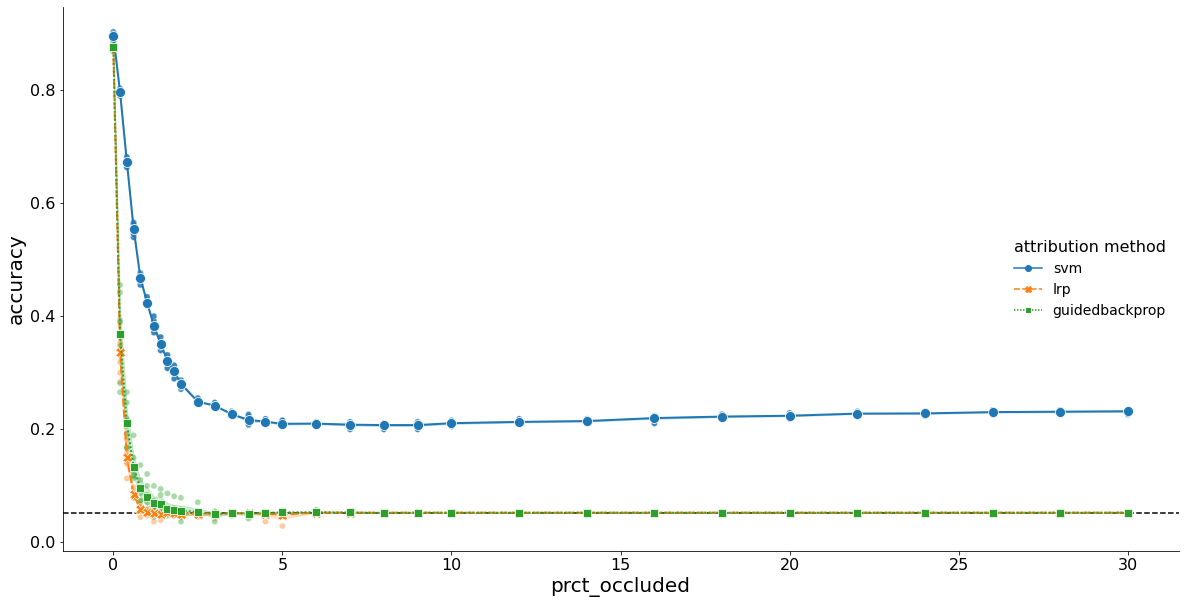

In [35]:
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

df_occlusion = pd.concat([df_stacked, df_occlusion])

fig, ax = plt.subplots(figsize=(20, 10))
sns.scatterplot(ax=ax, data=df_occlusion, x="prct_occluded", y="accuracy", hue="algorithm", alpha=.4, legend=False, zorder=0)
sns.lineplot(ax=ax, data=df_occlusion, x="prct_occluded", y="accuracy", hue="algorithm", style="algorithm", 
             errorbar=("ci", 95), n_boot=1000, linewidth=2, markers=True, markersize=10)
ax.axhline(1/len(class_labels), color="black", linestyle="--", zorder=0)
ax.legend(frameon=False, loc="center right", title="attribution method", fontsize=14)
ax.spines[["top", "right"]].set_visible(False)

plt.savefig("figures/occlusion_curves.pdf", facecolor=fig.get_facecolor(), transparent=True)

# Compute and investigate mutual information between different combination of attribution- and (group) t-mapssort_values

Mutual information can help us understand how similar the attribution maps of the LRP or GBP algorithm are to the original data format, i.e., t-statistics maps of single subjects or of the group. 

We can further perform some sanity checks this way:
* Comparing attribution maps obtained by networks trained with real input-label mappings to those with shuffled mappings can tell us something about the sensitivity to network parameters
* Comparing attribution maps to t-maps of single subjects or to the group t-maps allows us to judge how well the attribution maps reflect univariate statistics (may not be so fair because CNNs are multivariate!)
* We can see whether LRP or GBP has higher better mutual information to the original input data.

In [11]:
from sklearn.feature_selection import mutual_info_regression
from nilearn.masking import apply_mask
from nilearn.image import load_img

In [33]:
#mask = "stat-maps/motor_mask.nii.gz"
mask = mni_template
contrasts = ["subattr-vs-subt", "attr-real-vs-shuffled", 
             "subattr-vs-grpt", "grpattr-vs-grpt",
             "subattr-vs-grpattr", "subt-vs-grpt"]

fold = BEST_FOLD

for i, contrast in enumerate(contrasts):
    test = compute_mi(class_labels, mask, "mi_whole-brain", fold=fold, attr_methods=["lrp", "guidedbackprop"], contrast=contrast)

Computing MI for subattr-vs-subt


label: 0it [00:00, ?it/s]

Computing MI for attr-real-vs-shuffled


label: 0it [00:00, ?it/s]

Computing MI for subattr-vs-grpt


label: 0it [00:00, ?it/s]

Computing MI for grpattr-vs-grpt


label: 0it [00:00, ?it/s]

Computing MI for subattr-vs-grpattr


label: 0it [00:00, ?it/s]

Computing MI for subt-vs-grpt


label: 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [38]:
# do it for the trained model vs rnd model
contrast = "model-trained-vs-rnd"
methods = ["lrp", "guidedbackprop"]
seed = 2020

fold = BEST_FOLD

mis_list = []
mask = mni_template
for m, method in enumerate(methods):
    
    
    for c, lbl in enumerate(class_labels):
        X = apply_mask(f"{method}/model-random/fold-00/{lbl}.nii.gz", mask)
        y = apply_mask(f"{method}/real/fold-{fold:02d}/{lbl}.nii.gz", mask)
        
        mi = np.zeros(len(X))
        
        for i in range(len(X)):
            mi[i] = mutual_info_regression(X=X[i, :].reshape(-1, 1), y=y[i, :],
                                           discrete_features=False, random_state=seed)
        mis_list.append(
            pd.DataFrame({"mi": mi.tolist(), "class": lbl, "fold": fold,
                          "attr_method": method, "contrast": contrast}))

mis = pd.concat(mis_list)
mis.to_csv(f"stats/mi_whole-brain_{contrast}.csv", index=False)

In [86]:
# just compute the pearsons correlation too, to see if a linear measure would lead to larger similarity
# do it for the trained model vs rnd model
contrast = "pearsons_r"
methods = ["lrp", "guidedbackprop"]
seed = 2020

fold = BEST_FOLD

rho_list = [] 
mask = mni_template
for m, method in enumerate(methods):
    
    for c, lbl in enumerate(class_labels):
        
        X = apply_mask(f"{method}/real/fold-{fold:02d}/avg/{lbl}.nii.gz", mask)
        y = apply_mask(f"stat-maps/orig/{lbl}_z_score.nii.gz", mask)
                
        rho = np.corrcoef(X, y)[0,1]
            
        rho_list.append(
            pd.DataFrame({"values": rho.tolist(), "class": lbl, "fold": fold,
                          "attr_method": method, "contrast": contrast, "measure": "pearsons_r"}, index=[c]))

df_rho = pd.concat(rho_list)
df_rho.to_csv("./stats/rho_attrgrp-vs-grpt.csv", index=False)

## Plot the mutual information scores for the sanity checks (i.e., model trained vs model rnd; real labels vs shuffled labels)

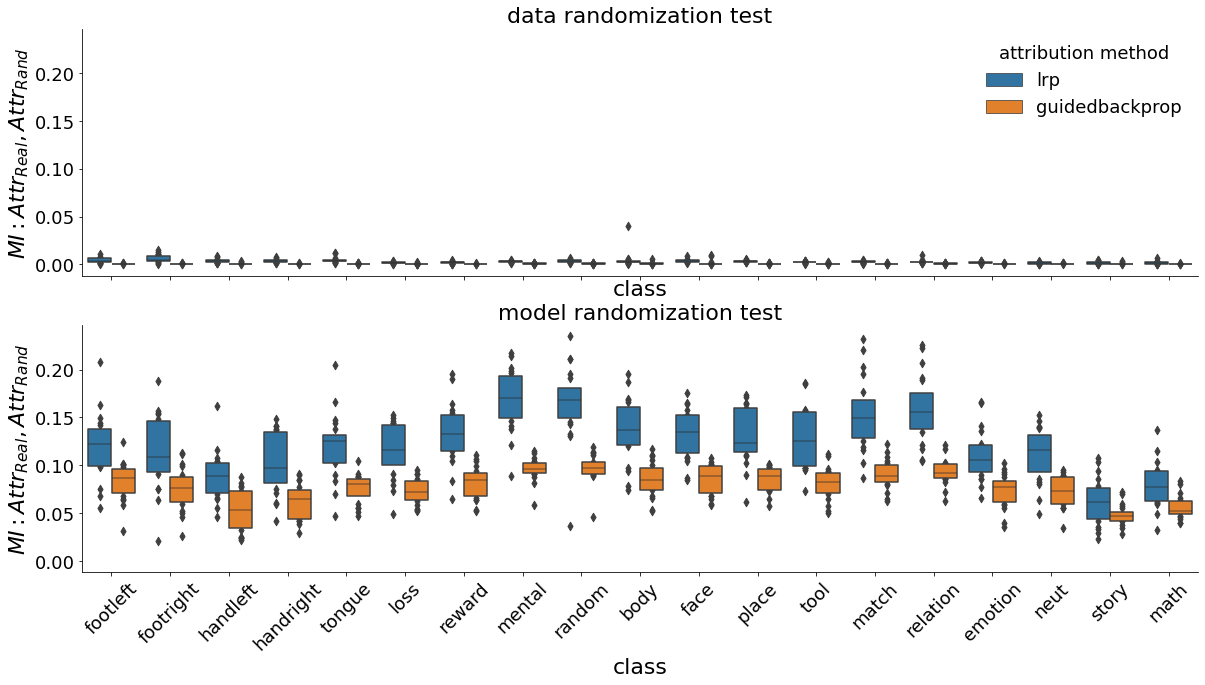

In [131]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10), sharex=True, sharey=True)

mis = pd.read_csv("stats/mi_whole-brain_attr-real-vs-shuffled.csv")
sns.boxenplot(ax=axes[0], data=mis[mis.fold==BEST_FOLD], x="class", y="mi", hue="attr_method")
axes[0].set_title("data randomization test");
axes[0].set_ylabel("$MI: Attr_{Real}, Attr_{Rand}$")

mis = pd.read_csv("stats/mi_whole-brain_model-trained-vs-rnd.csv")
sns.boxenplot(ax=axes[1], data=mis, x="class", y="mi", hue="attr_method")
axes[1].set_title("model randomization test");
axes[1].set_xticklabels(class_labels, rotation=45);
axes[1].set_ylabel("$MI: Attr_{Real}, Attr_{Rand}$")

for i, ax in enumerate(axes.flatten()):
    if i == 0:
        ax.legend(frameon=False, title="attribution method")
    else:
        ax.legend([],[], frameon=False)
    ax.spines[["top", "right"]].set_visible(False)
    
plt.savefig("figures/mi_sanity.pdf", facecolor=fig.get_facecolor(), transparent=True)

## Plot the mutual information scores for different comparisons

In [32]:
SMALL_SIZE = 18
MEDIUM_SIZE = 22
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

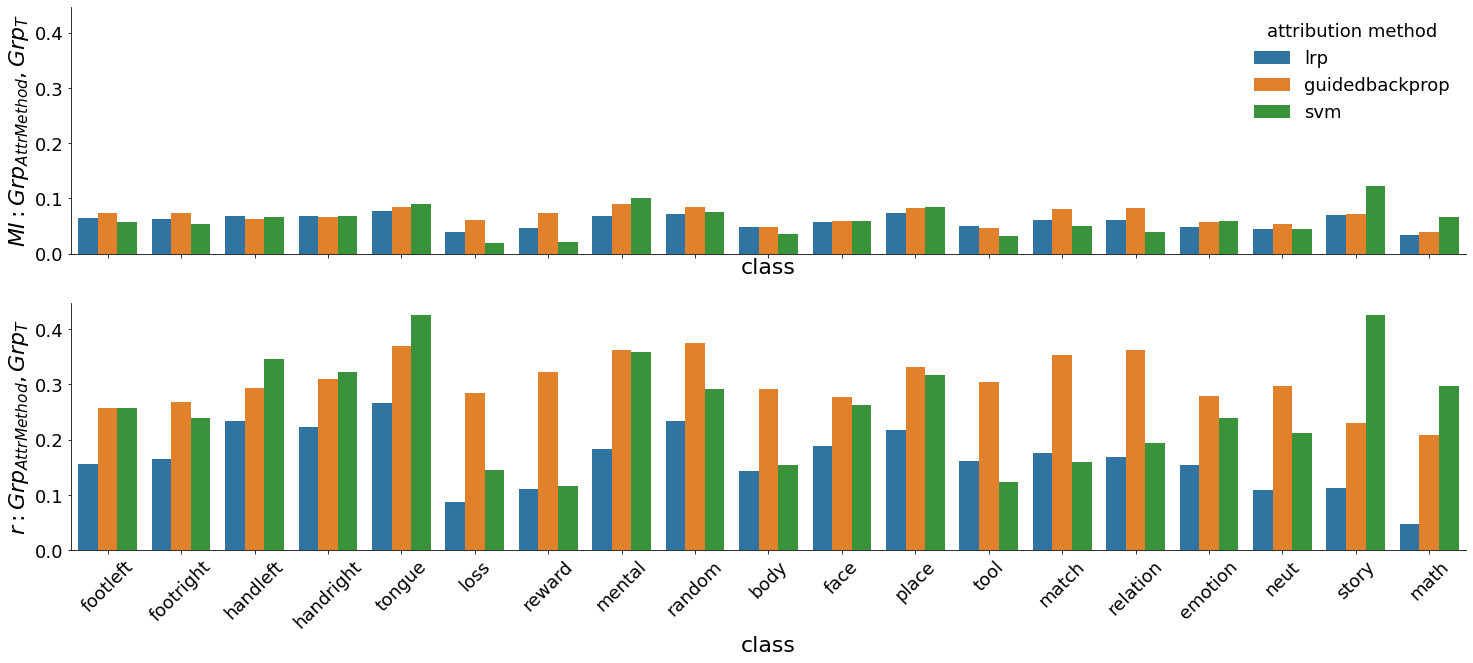

In [130]:
best_fold = 1
fig, axes = plt.subplots(2, 1, figsize=(25, 10), sharex=True, sharey=True)

# grpAttr vs grpt
df_svm = pd.read_csv("../00_svm/stats/rho_grpattr-vs-grpt.csv")
df_dnn = pd.read_csv("stats/rho_attrgrp-vs-grpt.csv")
df_rho = pd.concat([df_dnn, df_svm])
sns.barplot(ax=axes[1], data=df_rho, x="class", y="values", hue="attr_method")
axes[1].set_ylabel("$r: Grp_{AttrMethod}, Grp_{T}$")
axes[1].set_xticklabels(class_labels, rotation=45);

contrast = "grpattr-vs-grpt"
df_dnn = pd.read_csv(f"stats/mi_whole-brain_{contrast}.csv")
df_dnn = df_dnn[df_dnn.fold==best_fold]
df_dnn = df_dnn.rename(columns={"mi": "values"})
df_dnn['measure'] = "mi"
df_svm = pd.read_csv("../00_svm/stats/mi_grpattr-vs-grpt.csv")

df_mi = pd.concat([df_dnn, df_svm])
sns.barplot(ax=axes[0], data=df_mi, x="class", y="values", hue="attr_method")
axes[0].set_ylabel("$MI: Grp_{AttrMethod}, Grp_{T}$")
axes[0].set_xticklabels(class_labels, rotation=45);

for i, ax in enumerate(axes.flatten()):
    if i == 0:
        ax.legend(frameon=False, title="attribution method")
    else:
        ax.legend([],[], frameon=False)
    ax.spines[["top", "right"]].set_visible(False)
    
plt.savefig("figures/mi-vs-svm.pdf", facecolor=fig.get_facecolor(), transparent=True)

In [44]:
SMALL_SIZE = 18
MEDIUM_SIZE = 22
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

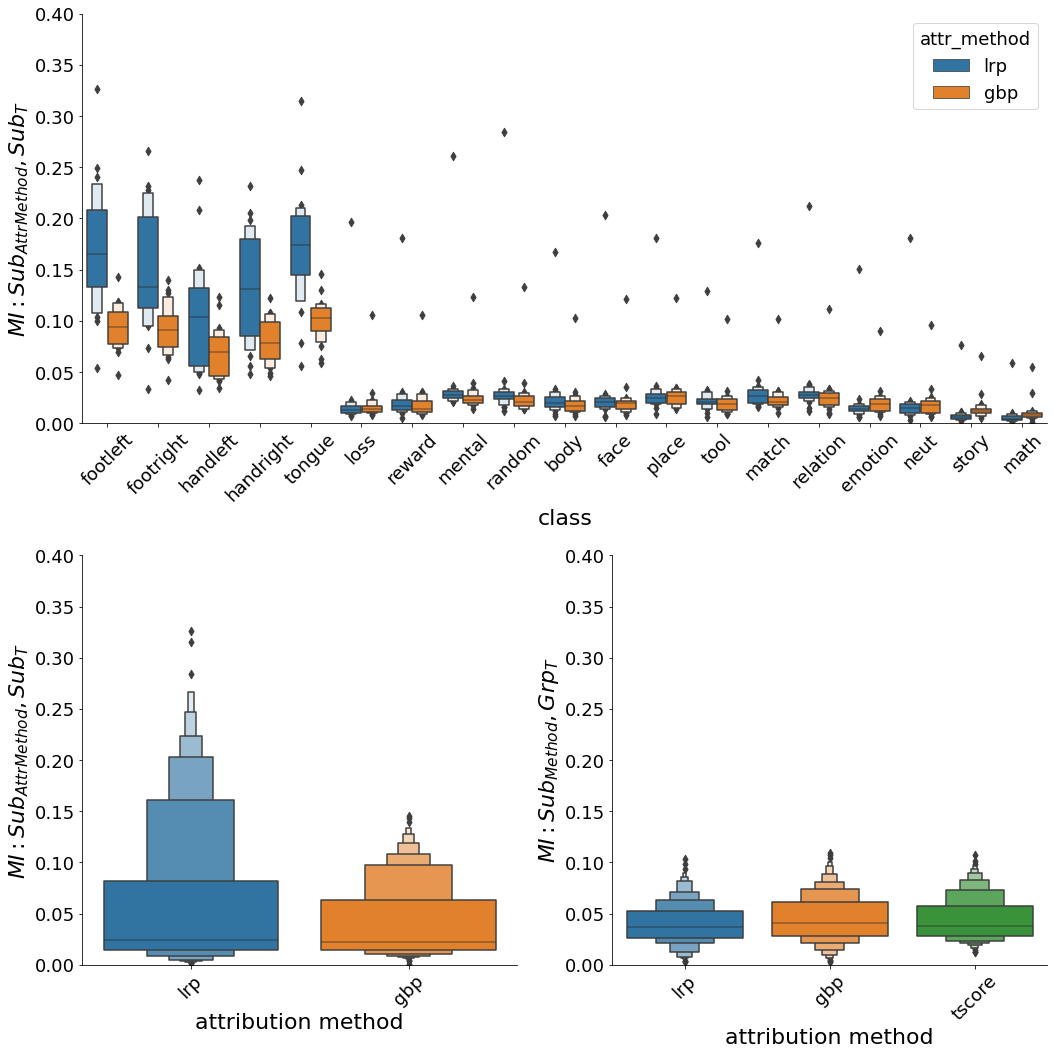

In [46]:
masks = ["whole-brain"]#, "motor-mask"]
best_fold = 1

fig = plt.figure(figsize=(15, 15))
plt.subplot2grid((2, 2), (0, 0), colspan=2)
# subattr-vs-subt
contrast = "subattr-vs-subt"
df = pd.read_csv(f"stats/mi_whole-brain_{contrast}.csv")
df = df[df.fold==best_fold]
df = df.replace("guidedbackprop", "gbp")
sns.boxenplot(data=df, x="class", hue="attr_method", y="mi", k_depth="trustworthy")
plt.gca().set_ylabel("$MI: Sub_{AttrMethod}, Sub_{T}$")
plt.gca().set_xticklabels(class_labels, rotation=45)
plt.gca().spines[["top", "right"]].set_visible(False)
plt.ylim([0, .4])

plt.subplot2grid((2, 2), (1, 0), colspan=1)
sns.boxenplot(data=df, x="attr_method", y="mi", k_depth="trustworthy")
plt.gca().set_ylabel("$MI: Sub_{AttrMethod}, Sub_{T}$")
plt.gca().set_xticklabels(df["attr_method"].unique(), rotation=45);
plt.gca().set_xlabel("attribution method")
plt.gca().spines[["top", "right"]].set_visible(False)
plt.ylim([0, .4])

plt.subplot2grid((2, 2), (1, 1), colspan=1)
contrast = "subattr-vs-grpt"
df = pd.read_csv(f"stats/mi_whole-brain_{contrast}.csv")
df = df[df.fold==best_fold]
df = df.replace("guidedbackprop", "gbp")

df2 = pd.read_csv("stats/mi_whole-brain_subt-vs-grpt.csv")

test = pd.concat([df, df2])
sns.boxenplot(data=test, x="attr_method", y="mi", k_depth="trustworthy")
plt.gca().set_ylabel("$MI: Sub_{Method}, Grp_{T}$")
plt.gca().set_xlabel("attribution method")
plt.gca().set_xticklabels(test.attr_method.unique(), rotation=45)
plt.gca().spines[["top", "right"]].set_visible(False)
plt.ylim([0, .4])

fig.tight_layout()
plt.savefig("figures/mi_whole-brain.pdf", facecolor=fig.get_facecolor(), transparent=True)

In [58]:
print(test[test.attr_method=="tscore"].mi.mean(), test[test.attr_method=="tscore"].mi.std())

0.043852971565623115 0.020551273986168034


# TEST

In [1]:
from nilearn.image import smooth_img

In [ ]:
# do it for the trained model vs rnd model
contrast = "subattr-vs-grpt"
methods = ["lrp", "guidedbackprop"]
seed = 2020

fold = BEST_FOLD

mis_list = []
mask = mni_template
for m, method in enumerate(methods):
    
    
    for c, lbl in tqdm(enumerate(class_labels), desc="label"):
        # load the images, smooth them, mask them
        #X = apply_mask(smooth_img(load_img(f"{method}/real/fold-01/{lbl}.nii.gz"), fwhm=3), mask)
        X = apply_mask(load_img(f"{method}/real/fold-01/{lbl}.nii.gz"), mask)
        
        mi = np.zeros(len(X))
        
        for i in range(len(X)):
            y = apply_mask(f"stat-maps/orig/left-out/{lbl}_wo-sub{i:02d}_z_score.nii.gz", mask)
            mi[i] = mutual_info_regression(X=X[i, :].reshape(-1, 1), y=y,
                                           discrete_features=False, random_state=seed)
        mis_list.append(
            pd.DataFrame({"mi": mi.tolist(), "class": lbl, "fold": fold,
                          "attr_method": method, "contrast": contrast}))
        
df_mi = pd.concat(mis_list)
df_mi.to_csv("./stats/mi_whole-brain_subattr-vs-grpt.csv", index=False)

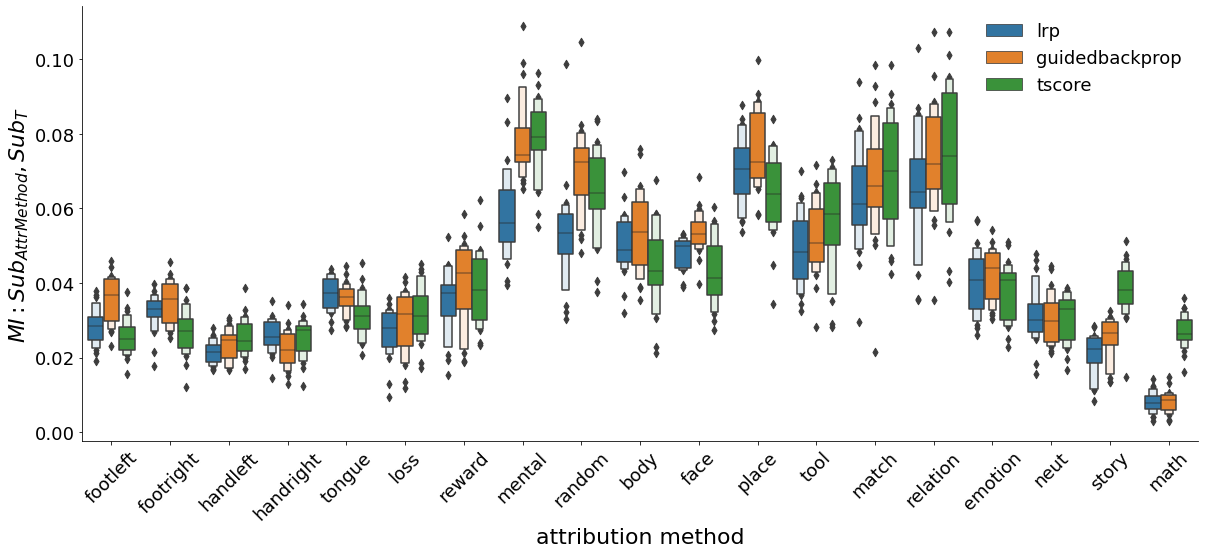

In [53]:
df = pd.concat([df_mi, pd.read_csv("./stats/mi_whole-brain_subt-vs-grpt.csv")])
fig, ax = plt.subplots(figsize=(20, 8))
sns.boxenplot(ax=ax, data=df, x="class", y="mi", hue="attr_method", k_depth="trustworthy")
plt.gca().set_ylabel("$MI: Sub_{AttrMethod}, Sub_{T}$")
plt.gca().set_xticklabels(df["class"].unique(), rotation=45);
plt.gca().set_xlabel("attribution method")
plt.gca().spines[["top", "right"]].set_visible(False)
ax.legend(frameon=False)